# Testing asymmetry on real data

## Fetching a sample

We can test on a sample of HST-SPOGs, since we know they have SDSS and HST data. Would also like to see if they haave UNIONS and HSC coverage.

In [140]:
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 

from astropy.visualization import AsinhStretch, AsymmetricPercentileInterval, LogStretch
stretch = AsinhStretch(0.6)
norm    = AsymmetricPercentileInterval(10, 99.6)

Load in the dataset containing HST-SPOG ids, coordinates, and their control samples. This is already cross-matched with HST and SDSS.

In [2]:
data = pd.read_csv('data/catalogs/hst_spogs_controls.csv')
data = data.drop_duplicates(subset=['name']).reset_index()
data = data[['name','ra','dec','lmass50','z','dataset']]
data.to_csv('data/catalogs/hst_spogs_controls.csv', index=False)

### UNIONS
The deepest is CFIS r-band data, so that's what we use.

There are ID matches with UNIONS (selected by hand...) - they all have CFIS-r data.

In [100]:
# # From inspecting the cutouts service
# ids = [9,12,13,14,18,23,24,25,26,30,31,33,34,35,37,39,45,47,50,53,55,56,57,58,59,60,63,67,68,69,70,71,72,73]
# # ids = [ 9, 12, 13, 14, 18, 23, 24, 25, 26, 30, 31, 34, 35, 56, 57, 58, 59,
# #        60, 67, 68, 69, 70, 71, 72, 73, 27, 32, 36, 38, 40, 46, 48, 51, 54,
# #        61, 64]
# # ids2 = [27, 32, 36, 38, 40, 46, 48, 51, 54, 61, 64]

# # Save these as unions-detected
# data['cfis'] = False
# data.loc[ids, 'cfis'] = True

### HSC

This is i-band data.

Now use the HSC cutout service to see which galaxies have HSC data. For this, we need a tab-delimited table with just `name`, `ra`, and `dec`, and the header should begin with `#? `.

In [103]:
# hsc_cutouts = data[['name','ra','dec']].copy()
# hsc_cutouts.to_csv('data/catalogs/hsc_cutouts_lookup.csv',index=False,sep='\t')

hsc_data = ! ls data/hsc/
hsc_data = [name[:-5] for name in hsc_data]
data['hsc'] = False
data.loc[data["name"].isin(hsc_data), "hsc"] = True

### SDSS

Now, fetch raw SDSS data (r- and i-band) for each galaxy, and make 40 arcsecond cutouts to match the HSC cutouts.

In [104]:
# sdss_data = pd.read_csv('data/catalogs/sdss_info.csv')
# sdss_data = sdss_data[['objID','camCol','rerun','field']]

In [159]:
sample = data[data.hsc]

for idx, row in tqdm(sample.iloc[24:].iterrows(), total=len(sample)):


    fig, axs = plt.subplots(1,3, figsize=(15,5))

    # SDSS
    file = fits.open(f'data/sdss/i/{row["name"]}.fits')
    axs[0].imshow(-2.5*np.log10(1e-9*np.abs(file[0].data) / 0.396**2), cmap='gray_r', vmin=20, vmax=30)
    axs[0].annotate('SDSS', xy=(0.05, 0.97), xycoords='axes fraction', color='w', size=14, va='top')
    file.close()

    # HSC
    file = fits.open(f'data/hsc/{row["name"]}.fits')
    axs[1].imshow(-2.5*np.log10(np.abs(file[1].data.T[::-1] / file[0].header['FLUXMAG0'] / 0.168**2 )), cmap='gray_r', vmin=20, vmax=30)
    axs[1].annotate('HSC', xy=(0.03, 0.97), xycoords='axes fraction', color='w', size=14, va='top')
    file.close()


    # HST
    file = fits.open(f'data/hst/F814W/{row["name"]}.fits')
    im = axs[2].imshow(-2.5*np.log10(np.abs(file[0].data) / file[0].header['pxscale']**2) + file[0].header['zp'], cmap='gray_r', vmin=20, vmax=30)
    color = 'w' if np.sum(file[1].data[:50,:50]) < 1000 else 'k'
    axs[2].annotate('HST', xy=(0.03, 0.97), xycoords='axes fraction', color=color, size=14, va='top')
    # file.close()

    for ax in axs:
        ax.axis('off')
    
    axs[0].annotate(row['name'], xycoords='axes fraction', xy=(0.03, 0.03), va='bottom', ha='left', color='w', size=14)
    
    plt.subplots_adjust(wspace=0.01, hspace=0.01, left=0, bottom=0, top=1, right=0.96)
    cax = fig.add_axes([0.965, 0, 0.01, 1])
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label(r'SB [mag/arcsec$^2$]', size=14)
    plt.savefig(f'figures/hst_sdss_hsc/{row["name"]}.png', bbox_inches='tight')
    plt.close(fig)

  3%|██▏                                                             | 1/30 [00:00<00:19,  1.49it/s]/var/folders/_w/6csvq9qx0611l8s_lvbrrpyh0000gn/T/ipykernel_7239/3938616340.py:23: RuntimeWarning: divide by zero encountered in log10
  im = axs[2].imshow(-2.5*np.log10(np.abs(file[0].data) / file[0].header['pxscale']**2) + file[0].header['zp'], cmap='gray_r', vmin=20, vmax=30)
 20%|████████████▊                                                   | 6/30 [00:03<00:13,  1.72it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'data/hst/F814W/J143451+033843.fits'

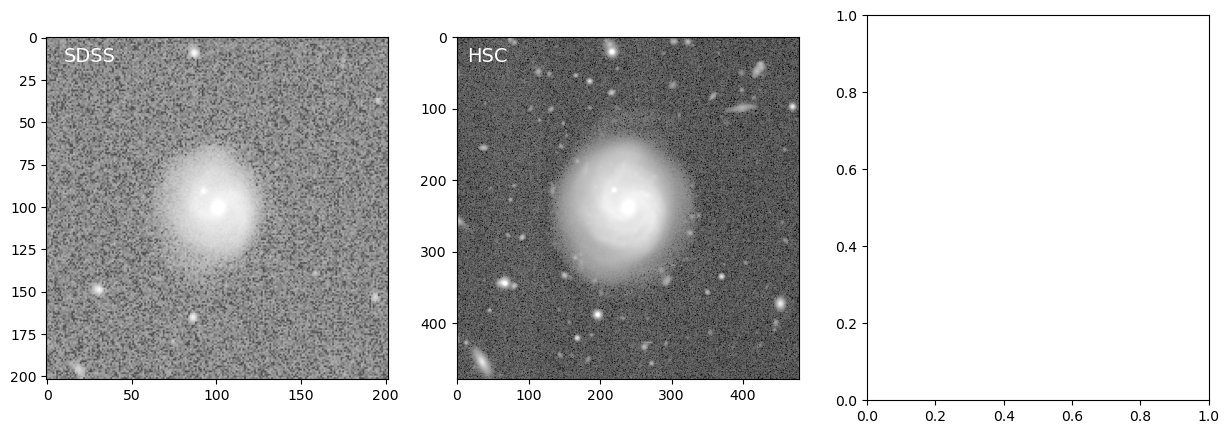

In [157]:
galaxy = 'J143451+033843'
# galaxy = 'J000318+004844'
# galaxy = 'J09'

fig, axs = plt.subplots(1,3, figsize=(15,5))

# SDSS
file = fits.open(f'data/sdss/i/{galaxy}.fits')
axs[0].imshow(-2.5*np.log10(1e-9*np.abs(file[0].data) / 0.396**2), cmap='gray_r', vmin=20, vmax=30)
axs[0].annotate('SDSS', xy=(0.05, 0.97), xycoords='axes fraction', color='w', size=14, va='top')
file.close()

# HSC
file = fits.open(f'data/hsc/{galaxy}.fits')
axs[1].imshow(-2.5*np.log10(np.abs(file[1].data.T[::-1] / file[0].header['FLUXMAG0'] / 0.168**2 )), cmap='gray_r', vmin=20, vmax=30)
axs[1].annotate('HSC', xy=(0.03, 0.97), xycoords='axes fraction', color='w', size=14, va='top')
file.close()


# HST
file = fits.open(f'data/hst/F814W/{galaxy}.fits')
axs[2].imshow(-2.5*np.log10(np.abs(file[0].data) / file[0].header['pxscale']**2) + file[0].header['zp'], cmap='gray_r', vmin=20, vmax=30)
axs[2].annotate('HST', xy=(0.03, 0.97), xycoords='axes fraction', color='w', size=14, va='top')
file.close()

for ax in axs:
    ax.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.01)

In [158]:
data[data.hsc]

,name,ra,dec,lmass50,z,dataset,cfis,hsc
0,J000318+004844,0.825888,0.812301,10.820000,0.138889,spog,False,True
1,J001145-005431,2.938389,-0.908503,10.221996,0.047883,spog,False,True
2,J002232+002127,5.632805,0.357513,10.150000,0.047105,control_sfg,False,True
10,J085357+031034,133.486704,3.175993,11.000000,0.129185,spog,False,True
19,J095750-001239,149.456404,-0.210907,10.170000,0.033022,spog,False,True
20,J095752+022908,149.465700,2.485481,10.390000,0.091566,control_qg,False,True
21,J095757+020656,149.488404,2.115574,10.610000,0.125197,control_sfg,False,True
22,J095800+022811,149.497700,2.469590,10.600000,0.119431,control_sfg,False,True
23,J095853+022603,149.720006,2.434196,10.870000,0.125027,control_qg,True,True
24,J095859+021500,149.743904,2.249749,10.960000,0.132862,control_sfg,True,True


### HST

Download the control sample

In [138]:
hst_control = pd.read_csv('data/catalogs/hst_control_fileinfo.csv')

with open('data/hst/raw/dl.txt', 'w') as f:
    s = 'https://hla.stsci.edu/cgi-bin/getdata.cgi?dataset='
    for idx, row in hst_control.iterrows():
        f.write(f'{s}{row.filename}_drz.fits\n')

In [85]:
file = fits.open(f'data/hsc/{galaxy}.fits')
tmp = file[0].data
# file.close()

/var/folders/_w/6csvq9qx0611l8s_lvbrrpyh0000gn/T/ipykernel_7239/91556476.py:1: RuntimeWarning: invalid value encountered in log10
  plt.imshow(-2.5*np.log10(tmp / 0.396**2)+9)


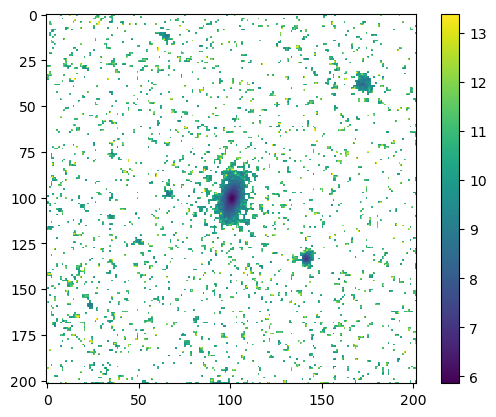

In [72]:
plt.imshow(-2.5*np.log10(tmp / 0.396**2)+9)
plt.colorbar()

In [88]:
file[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  477                                                  
NAXIS2  =                  477                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    2 / Number of WCS axes                             
CRPIX1  =               -11064 / Reference pixel on axis 1                      
CRPIX2  =                -4109 / Reference pixel on axis 2                      
CRVAL1  =     150.247933884298 / Value at ref. pixel on axis 1                  
CRVAL2  =     2.23140495867768 / Value at ref. pixel on axis 2                  
CTYPE1  = 'RA---TAN'        

/var/folders/_w/6csvq9qx0611l8s_lvbrrpyh0000gn/T/ipykernel_7239/797964823.py:1: RuntimeWarning: invalid value encountered in log10
  plt.imshow(-2.5*np.log10(tmp / 0.396**2) + 9*2.5)


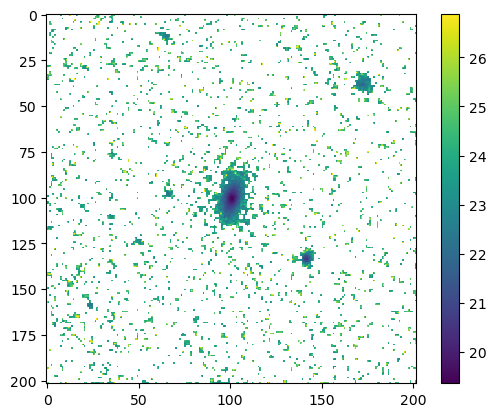

In [79]:
plt.imshow(-2.5*np.log10(tmp / 0.396**2) + 9*2.5)
plt.colorbar()